## Would you survive the Titanic using Python ML & DNN
* 1) cross_validation -> model_selection 
* 2) the use of DNN estimator.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics, ensemble
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
titanic_df = pd.read_csv('train.csv')

### From EDA, we learned that these features are strong indicators for survivability:

* 1) Being a woman
* 2) Being in 1st Class
* 3) Being young, especially less than 10 years old

### Data Preparation

In [3]:
titanic_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

From EDA, I chose Age, Sex, and Fare to be most important. Though, SibSP, Parch, and especially PClass, and of course, Survived are all useful indicators. Cabin is missing too many values and meaningfully, it's less important. Same as Name, Embarked and Ticket (but who knows, the machine thinks better than I do after running ML). PassengerId can go away, and I think we can all agree on that one.

### Dropping and filling in missing values

In [4]:
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)

In [5]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [6]:
titanic_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

As I mentioned, for Age, we will try with dropping the missing values first, then try with filling it with mean values.

In [7]:
titanic_df = titanic_df.dropna()

In [8]:
titanic_df.count()

Survived    714
Pclass      714
Sex         714
Age         714
SibSp       714
Parch       714
Fare        714
dtype: int64

In [9]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


We see that sex is the only non-numerical (categorical in this case) column. So, for an easier implementation to our DNN model, I will change the Sex category into 1 for male and 0 for female.

### Helper Functions

In [10]:
def split_data(df: pd.DataFrame):
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    num_rows = df.shape[0]
    num_rows_train_data = int(num_rows * 0.8)

    train_data = df_shuffled[:num_rows_train_data]
    val_data = df_shuffled[num_rows_train_data:]
    
    return (train_data, val_data)

def input_fn(df: pd.DataFrame, labels, batch_size: int, num_epochs: int):
    if labels is None:
        input = df.to_dict(orient='series')
    else:
        input = (df.to_dict(orient='series'), labels)
    dataset = tf.data.Dataset.from_tensor_slices(input)
    return dataset.shuffle(buffer_size=10000).repeat(count=num_epochs).batch(batch_size)

def eval_input_fn(df: pd.DataFrame, labels):
    if labels is None:
        input = df.to_dict(orient='series')
    else:
        input = (df.to_dict(orient='series'), labels)
    dataset = tf.data.Dataset.from_tensor_slices(input)
    return dataset.batch(128)

def embedding_dimension(unique_count):
    return min(50, unique_count // 2)

def define_feature_columns(df: pd.DataFrame, numeric_columns, categorical_columns):
    feature_columns = []
    for col in df.columns:
        if col in categorical_columns:
            sorted_unique_values = sorted(set(list(df[col].unique()) + ['']))
            cat_col = tf.feature_column.categorical_column_with_vocabulary_list(key=col, vocabulary_list=sorted_unique_values)
            embedding_dim = embedding_dimension(len(sorted_unique_values))
            if embedding_dim <= 2:
                feature_columns.append((col, tf.feature_column.indicator_column(cat_col)))
            else:
                feature_columns.append((col, tf.feature_column.embedding_column(cat_col, embedding_dim)))
        elif col in numeric_columns:
            feature_columns.append((col, tf.feature_column.numeric_column(key=col)))
            isnull_col_name = col + 'IsNull'
            feature_columns.append((isnull_col_name, tf.feature_column.numeric_column(key=isnull_col_name)))
    return dict(feature_columns)

def feature_preprocess(df: pd.DataFrame, numeric_columns, categorical_columns, col_mean, col_stddev):
    processed = pd.DataFrame()
    processed['PassengerId'] = df['PassengerId']
    
    for col_name in numeric_columns:
        processed[col_name] = (df[col_name].astype(float) - col_mean[col_name]) / col_stddev[col_name]
        isnull_col_name = col_name + 'IsNull'
        processed[isnull_col_name] = df[col_name].isnull()
        processed.loc[processed[isnull_col_name], col_name] = 0
        processed[isnull_col_name] = processed[isnull_col_name].astype(np.int8)
        
    for col_name in categorical_columns:
        processed[col_name] = df[col_name].copy().astype(str)
        processed.loc[df[col_name].isnull(), col_name] = ''
    
    return processed

### DNN

In [11]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

train_data, val_data = split_data(train_csv)
print(train_data.shape, val_data.shape)

(712, 12) (179, 12)


In [12]:
numeric_columns = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_columns = ['Pclass', 'Sex']

col_mean = train_data[numeric_columns].mean()
col_stddev = train_data[numeric_columns].std()

def feature_preprocess_1(df: pd.DataFrame):
    return feature_preprocess(df, numeric_columns=numeric_columns, categorical_columns=categorical_columns, col_mean=col_mean, col_stddev=col_stddev)

train_features = feature_preprocess_1(train_data)
val_features = feature_preprocess_1(val_data)

print(train_features.head())

feature_columns = define_feature_columns(
    train_features,
    numeric_columns=numeric_columns,
    categorical_columns=categorical_columns)

classifier = tf.estimator.DNNClassifier(
    feature_columns=list(feature_columns.values()),
    hidden_units=[64, 32, 16],
    n_classes=2,
    dropout=0.5)

   PassengerId       Age  AgeIsNull     SibSp  SibSpIsNull     Parch  \
0          197  0.000000          1 -0.477922            0 -0.486132   
1          865 -0.372691          0 -0.477922            0 -0.486132   
2          859 -0.372691          0 -0.477922            0  3.345522   
3          799  0.048407          0 -0.477922            0 -0.486132   
4           45 -0.723605          0 -0.477922            0 -0.486132   

   ParchIsNull      Fare  FareIsNull Pclass     Sex  
0            0 -0.493148           0      3    male  
1            0 -0.387567           0      2    male  
2            0 -0.261710           0      3  female  
3            0 -0.503621           0      3    male  
4            0 -0.490549           0      3  female  


In [13]:
classifier.train(input_fn=lambda: input_fn(train_features, train_data['Survived'], batch_size=64, num_epochs=500))

In [14]:
classifier.evaluate(input_fn=lambda: eval_input_fn(val_features, val_data['Survived']))

{'accuracy': 0.82122904,
 'accuracy_baseline': 0.60335195,
 'auc': 0.8540689,
 'auc_precision_recall': 0.852542,
 'average_loss': 0.48437542,
 'label/mean': 0.39664805,
 'loss': 43.3516,
 'precision': 0.8679245,
 'prediction/mean': 0.35210833,
 'recall': 0.64788735,
 'global_step': 5563}

In [15]:
submit_data = feature_preprocess_1(test_csv)

predictions = classifier.predict(input_fn=lambda: eval_input_fn(submit_data, None))
predictions = list(predictions)

In [16]:
submit_output_csv = pd.DataFrame({'PassengerId': submit_data['PassengerId'], 'Survived': [x['class_ids'][0] for x in predictions]})
submit_output_csv.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [17]:
submit_output_csv.to_csv('submit_output_1.csv', index=False)
submit_output = pd.read_csv('submit_output_1.csv')
submit_output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# Second Version of DNN

### Main Structure

* EDA has been done on other jupyter file already
* feature engineering : throw away useless feature, and transforming usable feature
* data cleaning and normalization (fill N/A, and separate categories)
* train/test separation
* neural network design
* train and predict

In [18]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

In [19]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [20]:
#remove useless feature
for df in [train, test]:
    df.drop(labels=["PassengerId", "Cabin", "Name", "Ticket"], axis=1, inplace=True)

In [21]:
# fill missing value
# another way is to use sklearn imputation to fill na
for df in [train, test]:
    for col in ["Age", "Fare"]:
        df[col] = df[col].fillna(np.mean(df[col]))

In [22]:
# data normalization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
for df in [train, test]:
    for col in ["Age", "Fare"]:
        x = df[[col]].values.astype(float)
        df[col] = min_max_scaler.fit_transform(x)

In [23]:
# transform string
for df in [train, test]:
    # remove duplicate features to avoid overfitting
    #df['is_male'] = np.where(df['Sex']=="male", 1, 0)
    df['is_female'] = np.where(df['Sex']=="female", 1, 0)
    df['EmbarkedS'] = np.where(df['Embarked']=="S", 1, 0)
    df['EmbarkedC'] = np.where(df['Embarked']=="C", 1, 0)
    df['EmbarkedQ'] = np.where(df['Embarked']=="Q", 1, 0)
    df['Pclass1'] = np.where(df['Pclass']==1, 1, 0)
    df['Pclass2'] = np.where(df['Pclass']==2, 1, 0)
    df['Pclass3'] = np.where(df['Pclass']==3, 1, 0)
    df['is_single'] = np.where(np.logical_and(df['SibSp']==0, df['Parch']==0), 1, 0)

# then remove transformed columns
for df in [train, test]:
    df.drop(labels=["Sex", "Embarked", 'Pclass'], axis=1, inplace=True)

In [24]:
# load up train/validation set
train_size = int(train.shape[0] * 0.80)

train_dataset = train[:train_size]
val_dataset = train[train_size:]

X_train = train_dataset.drop(labels=["Survived"], axis=1).values
Y_train = train_dataset["Survived"].values

X_val = val_dataset.drop(labels=["Survived"], axis=1).values
Y_val = val_dataset["Survived"].values

input_size = len(train_dataset.columns) - 1  # number of final features 

In [25]:
X_train = X_train.reshape((X_train.shape[1], X_train.shape[0]))
X_val = X_val.reshape((X_val.shape[1], X_val.shape[0]))

Y_train = Y_train.reshape((1, Y_train.shape[0]))
Y_val = Y_val.reshape((1, Y_val.shape[0]))

In [26]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=[n_x, None])
    Y = tf.placeholder(tf.float32, shape=[n_y, None])
    return X, Y

def initialize_parameters():
    # when I increase this to 2 times of input, the cost decrease rapidly
    # when I increase this to 1000, boom! train acc get to 97%, but test acc is below 60%
    output_size = 1
    l1_size = 64 #int(input_size * 2) 
    l2_size = 64 #int(input_size * 1)
    l3_size = output_size#int(input_size * 1)
    l4_size = output_size
    
    W1 = tf.get_variable("W1", [l1_size, input_size],
                         initializer=tf.contrib.layers.xavier_initializer()) # seed=1
    b1 = tf.get_variable("b1", [l1_size, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [l2_size, l1_size], 
                         initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [l2_size, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [l3_size, l2_size], 
                         initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [l3_size, 1], initializer=tf.zeros_initializer())
    W4 = tf.get_variable("W4", [l4_size, l3_size], 
                         initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.get_variable("b4", [l4_size, 1], initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4
                 }

    return parameters

In [27]:
def forward_propagation(X, parameters):
    """
    LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Z3 -- the output of the last LINEAR unit
    """
    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']

    keep_prob = 0.7 #0.3  # if dropout too many, the predict result will be always 0
    Z1 = tf.add(tf.matmul(W1, X), b1)  # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.dropout(tf.nn.relu(Z1), keep_prob=keep_prob)  # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.dropout(tf.nn.relu(Z2), keep_prob=keep_prob)  # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)  # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.dropout(tf.nn.relu(Z3), keep_prob=keep_prob)  
    Z4 = tf.add(tf.matmul(W4, A3), b4)  

    return Z3

def forward_propagation_for_predict(X, parameters):
    """
    Returns: Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)  # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)  # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)  # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)  # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.relu(Z3)  # A2 = relu(Z2)
    Z4 = tf.add(tf.matmul(W4, A3), b4)  # Z3 = np.dot(W3,Z2) + b3

    return Z3

In [28]:
def compute_cost(Z3, Y):
    """
    Z3 -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as Z3
    Return: cost - Tensor of the cost function
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [29]:
def model(X_train, Y_train, X_val, Y_val, learning_rate=0.0001,
          num_epochs=1500, print_cost=True):
    """
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()  # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape  # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]  # n_y : output size
    costs, val_losses = [], []  # To keep track of the cost

    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()

    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)

    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    val_cost = compute_cost(forward_propagation_for_predict(X, parameters), Y)

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initialize all the variables
    init = tf.global_variables_initializer()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):
            _, epoch_cost = sess.run([optimizer, cost],
                                     feed_dict={X: X_train, Y: Y_train})

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                epoch_val_loss = sess.run(val_cost, feed_dict={X: X_val, Y: Y_val})
                if epoch % 100 == 0:
                    print ("Loss after epoch %i: training[%f] | dev[%f]" % (epoch, epoch_cost, epoch_val_loss))

                val_losses.append(epoch_val_loss)
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(val_losses))
        plt.legend(["training", "test"])
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        y_hat = tf.cast(tf.greater(tf.sigmoid(Z3),0.5), tf.float32)
        correct_prediction = tf.equal(y_hat, Y)

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy: ", "{:3.2f}%".format(100*accuracy.eval({X: X_train, Y: Y_train})))
        print ("Test Accuracy:", "{:3.2f}%".format(100*accuracy.eval({X: X_val, Y: Y_val})))

        return parameters

Loss after epoch 0: training[0.711873] | dev[0.688416]
Loss after epoch 100: training[0.652341] | dev[0.683140]
Loss after epoch 200: training[0.623979] | dev[0.701447]
Loss after epoch 300: training[0.599367] | dev[0.727636]
Loss after epoch 400: training[0.569313] | dev[0.759659]
Loss after epoch 500: training[0.545125] | dev[0.788319]
Loss after epoch 600: training[0.520479] | dev[0.811930]
Loss after epoch 700: training[0.525578] | dev[0.826573]
Loss after epoch 800: training[0.503016] | dev[0.849990]
Loss after epoch 900: training[0.467382] | dev[0.862952]
Loss after epoch 1000: training[0.459656] | dev[0.864968]
Loss after epoch 1100: training[0.446982] | dev[0.889252]
Loss after epoch 1200: training[0.457409] | dev[0.907090]
Loss after epoch 1300: training[0.453077] | dev[0.909110]
Loss after epoch 1400: training[0.408559] | dev[0.926227]
Loss after epoch 1500: training[0.414034] | dev[0.935220]
Loss after epoch 1600: training[0.388900] | dev[0.925385]
Loss after epoch 1700: tra

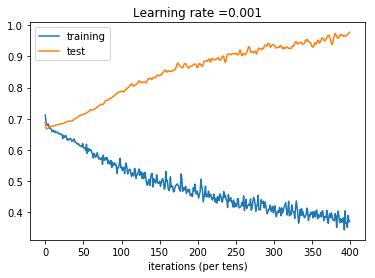

Parameters have been trained!
Train Accuracy:  82.72%
Test Accuracy: 53.63%


In [30]:
parameters = model(X_train, Y_train, X_val, Y_val,learning_rate=0.001, num_epochs=2000)

In [31]:
def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    b4 = tf.convert_to_tensor(parameters["b4"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
             "W4": W4,
              "b4": b4}

    x = tf.placeholder("float", [input_size, None])

    z3 = forward_propagation_for_predict(x, params)
    p = tf.sigmoid(z3) 

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})

    return prediction

In [32]:
# load up test set
final_test = test.values.T
y_pred = predict(final_test, parameters)

y_final = (y_pred > 0.5).astype(int).ravel()  #.reshape(X_val.shape[0])

In [33]:
df_test = pd.read_csv("test.csv")
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_final})
# output["Survived"].unique()
surv_num = sum(output["Survived"] != 0) / len(output)
print(f"Survive ratio: {surv_num}")

Survive ratio: 0.20813397129186603


In [34]:
output.to_csv('result_dnn.csv', index=False)
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,0
9,901,1
